In [1]:
import copy
import pywt
import h5py
import scipy.stats
import scipy.signal
import scipy.io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from kpnet.handler import *
from kpnet.network import *
from kpnet.signal import *
from kpnet.callback import *
from kpnet.entropy import *
from kpnet.patterns import *
from kpnet.utils import *

from wavelets import *

In [2]:
N = 64
time_interval = 2 ** 16
chunk = 2 ** 13

In [3]:
np.random.seed(0)
#neuron = 5
# 20, 0.078
# Period - N, 3, alpha=0.044, beta=0.2, gamma=3.2
net = KPNetworkTanh(N, alpha=0.05, beta=0.3, gamma=2.2)

callbacks = {}
callbacks['W'] = WeightsCallback(time_interval, N, chunk, 'data/data.hfd5')
signal = SwitchSignal([2000, time_interval], [RandomUnitSignal(N), ZeroSignal(N)])
handler = ComputationHandler(time_interval)
results = handler.run(net, signal, callbacks)

In [3]:
w_file    = h5py.File('data/data.hfd5', 'r')
swt_file  = h5py.File('data/swt.hfd5', 'r')

W   = w_file['W']
SWT = swt_file['SWT']

In [4]:
class SWTDistribution:
    def __init__(self, signal, wavelet):
        self.level = pywt.swt_max_level(signal.shape[0])
        self.swt   = np.asarray([D ** 2  for _, D in pywt.swt(signal, wavelet, level=self.level)])
        self.value = np.flip(np.sum(self.swt, axis=1) / np.sum(self.swt), axis=-1)
    
    @property
    def entropy(self):
        return scipy.stats.entropy(self.value)
    
    @property
    def moda(self):
        return np.argmax(self.value)
    
    def divergence(self, other):
        return scipy.stats.entropy(self.value, other.value)
    
    def jensen(self, other):
        return .5 * (self.divergence(other) + other.divergence(self))
    
def swt_scalogramm(signal, wavelet):
    return np.asarray([D ** 2  for _, D in pywt.swt(signal, wavelet, level=np.log2(signal.shape[0]))])

class DWTDistribution:
    def __init__(self, signal, wavelet):
        level = pywt.dwt_max_level(signal.shape[0], pywt.Wavelet(wavelet).dec_len)
        dwt = pywt.wavedec(signal, wavelet, level=level)
        self.power = np.asarray([np.sum(coeffs ** 2) for coeffs in dwt])
        self.power /= np.sum(self.power)
        self.value = np.flip(self.power, axis=-1)
    
    @property
    def entropy(self):
        return scipy.stats.entropy(self.value)
    
    @property
    def moda(self):
        return np.argmax(self.value)
    
    def divergence(self, other):
        return scipy.stats.entropy(self.value, other.value)
    
    def jensen(self, other):
        return .5 * (self.divergence(other) + other.divergence(self))

class CWTDistribution:
    def __init__(self, signal, wavelet):
        self.power = WaveletTransform(signal, wavelet=wavelet, mask_coi=True).wavelet_power
        self.power = np.sum(self.power, axis=1) / np.sum(self.power) 
        self.value = np.flip(self.power, axis=-1)
    
    @property
    def entropy(self):
        return scipy.stats.entropy(self.value)
    
    @property
    def moda(self):
        return np.argmax(self.value)
    
    def divergence(self, other):
        return scipy.stats.entropy(self.value, other.value)
    
    def jensen(self, other):
        return .5 * (self.divergence(other) + other.divergence(self))

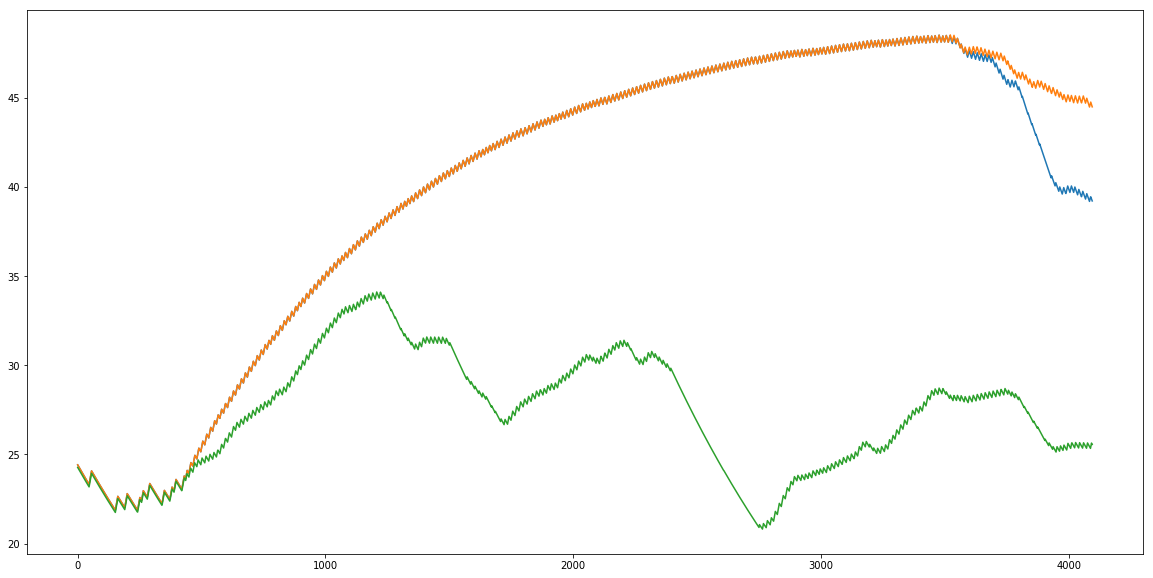

In [6]:
signal1 = W[5, 13, 6000:10096]
signal2 = W[5, 11, 6000:10096]
signal3 = W[5, 14, 6000:10096]

plt.figure(figsize=(20, 10))
plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)
plt.show()

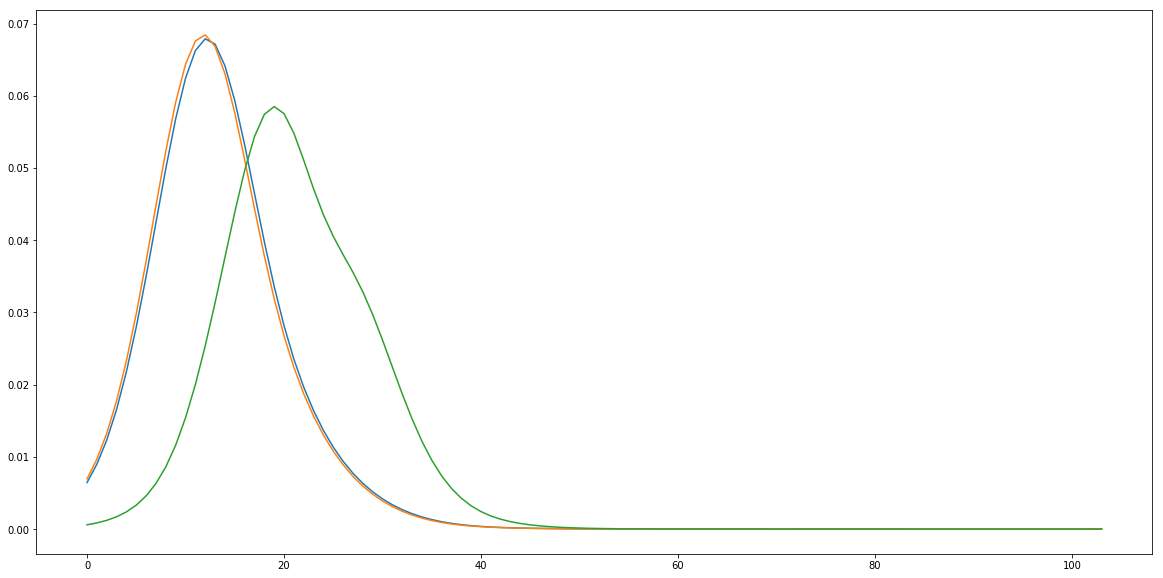

0.000981808280167
0.631549958154
3.25737100668
3.39168112253
12
12
19


In [7]:
dist1 = CWTDistribution(signal1, Ricker()) 
dist2 = CWTDistribution(signal2, Ricker())
dist3 = CWTDistribution(signal3, Ricker())

plt.figure(figsize=(20, 10))
plt.plot(dist1.value)
plt.plot(dist2.value)
plt.plot(dist3.value)
plt.show()

print(dist1.jensen(dist2))
print(dist1.jensen(dist3))
print(dist1.entropy)
print(dist3.entropy)

print(dist1.moda)
print(dist2.moda)
print(dist3.moda)

In [6]:
class SWTCluster:
    def __init__(self):
        self.vertexes  = []
        
    def push(self, v):
        self.vertexes.append(v)
       
    @property
    def cardinality(self):
        return len(self.vertexes)
    

class SWTClusterization:
    def __init__(self, W, begin, end, threshold, wavelet):
        self.W = W
        self.threshold = threshold
        self.begin     = begin
        self.end       = end
        self.wavelet   = wavelet
        
        self.clusters = []
        self.neurons  = self.W.shape[0]
        self.visited  = np.zeros(shape=(self.neurons, self.neurons), dtype='bool')
        
    def run(self):
        #for v in range(self.neurons):
        v = 5
        cluster = SWTCluster()
        cluster.push(v)
        for u in range(self.neurons):
            if v != u:
                self.visited[v, u] = True
                self.visited[u, v] = True
                self.explore(v, u, cluster)
        
        if cluster.cardinality > 1:
            self.clusters.append(cluster)
        return self.clusters
    
    def explore(self, v, u, cluster):
        for w in range(self.neurons):
            if not self.visited[v, w] and v != w:
                self.visited[v, w] = True
                self.visited[w, v] = True
                if self.connected(v, u, w):
                    cluster.push(u)
                    cluster.push(w)
                self.explore(v, w, cluster)

    def connected(self, v, u, w):
        udist = CWTDistribution(self.W[v, u, self.begin : self.end], self.wavelet)
        wdist = CWTDistribution(self.W[v, w, self.begin : self.end], self.wavelet)
        return (udist.jensen(wdist) <= self.threshold) and (udist.moda == wdist.moda)


In [5]:
def neuron_cluster(pattern, threshold):
    visited = [False] * N;
    clusters = []
    pdist = CWTDistribution(pattern, Ricker())
    for i in range(N):
        if not visited[i]:
            cluster = []
            for j in range(N):
                if not visited[j] and j != i:
                    jdist = CWTDistribution(W[i, j, 6000 : 10096], Ricker())
                    if jdist.jensen(pdist) <= threshold:
                        visited[j] = True
                        cluster.append(j)

            if len(cluster) > 0:
                clusters.append(cluster + [i])
                visited[i] = True
                
    return clusters
                    

In [6]:
pattern = W[25, 23, 6000:10096]

In [7]:
%time clusters = neuron_cluster(W[25, 23, 6000:10096], 0.003)

CPU times: user 5min 56s, sys: 1.25 s, total: 5min 58s
Wall time: 5min 58s


In [20]:
clusters

[[3, 5, 11, 13, 29, 31, 34, 36, 42, 0], [12, 58, 8], [25, 23], [63, 44]]

In [22]:
def cluster_adjmatrix(clusters):
    adj_matrix = np.zeros(shape=(N, N))
    for cluster in clusters:
        for elem1 in cluster:
            for elem2 in cluster:
                if elem1 != elem2:
                    adj_matrix[elem1, elem2] = 1
    return adj_matrix

[]

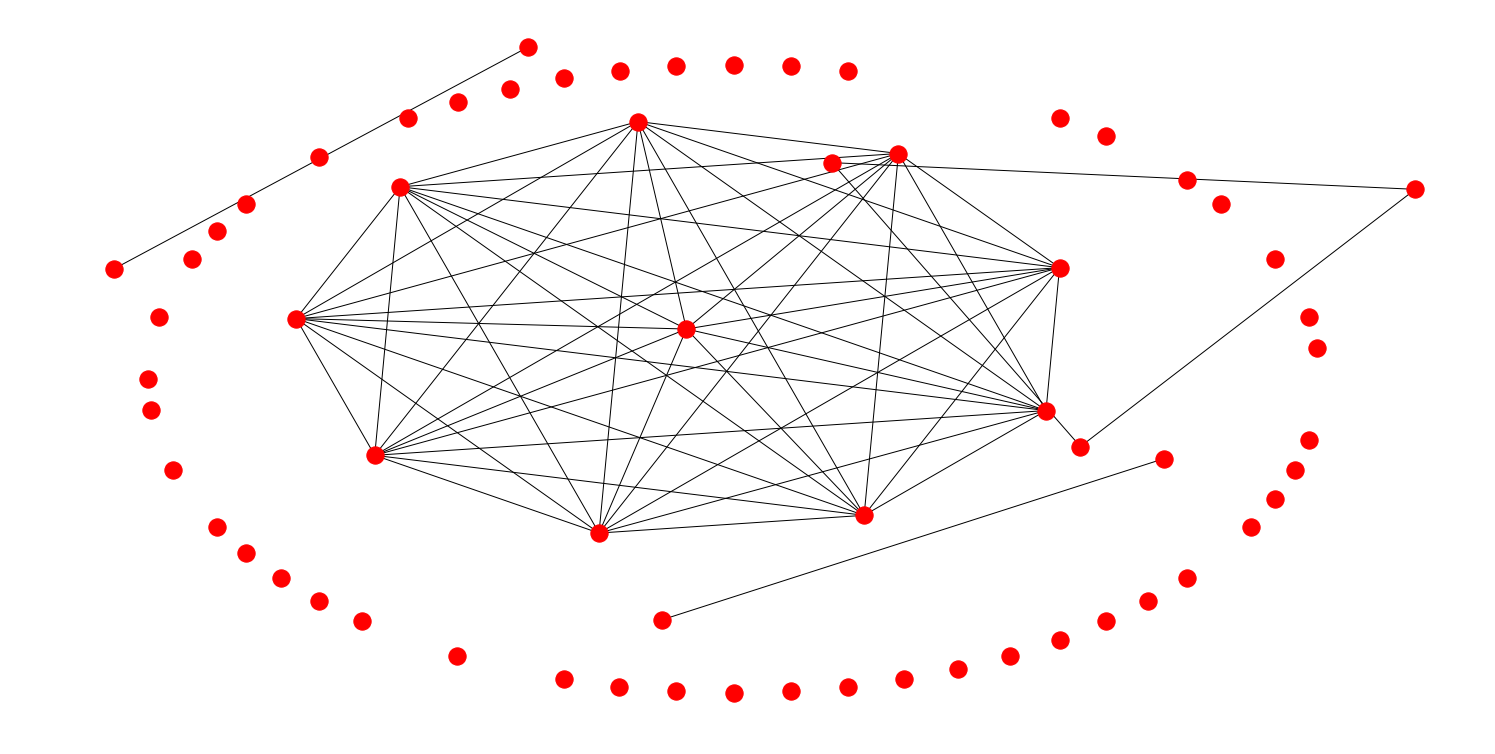

In [36]:
g = nx.from_numpy_array(cluster_adjmatrix(clusters))
plt.figure(figsize=(20, 10))
nx.draw_kamada_kawai(g)
plt.plot()

In [52]:
def draw_clustered_network(clusters):
    node_colors = [0.5] * N
    color_shift = 0.2
    for cluster in clusters:
        for elem in cluster:
            node_colors[elem] = color_shift
        color_shift += 0.2
    
    g = nx.from_numpy_matrix(cluster_adjmatrix(clusters))        
    plt.figure(figsize=(20, 10))
    pos = nx.kamada_kawai_layout(g)
    nx.draw_networkx_nodes(g, pos, node_color = node_colors, alpha = 0.7, node_size = 500)
    nx.draw_networkx_labels(g, pos, {i: str(i) for i in range(N)})
    black_edges = [(b, e) for b, e in g.edges()]
    #grey_edges = [(b, e) for b, e in g.edges() if (b in subs[-2]) and (e in subs[-2])]
    #white_edges = [edge for edge in g.edges() if edge not in black_edges]
    nx.draw_networkx_edges(g, pos, edge_color='gray')
#    nx.draw_networkx_edges(g, pos, edgelist=grey_edges, edge_color='gray')
#    nx.draw_networkx_edges(g, pos, edgelist=black_edges)
    plt.xticks([])
    plt.yticks([])
    plt.show()

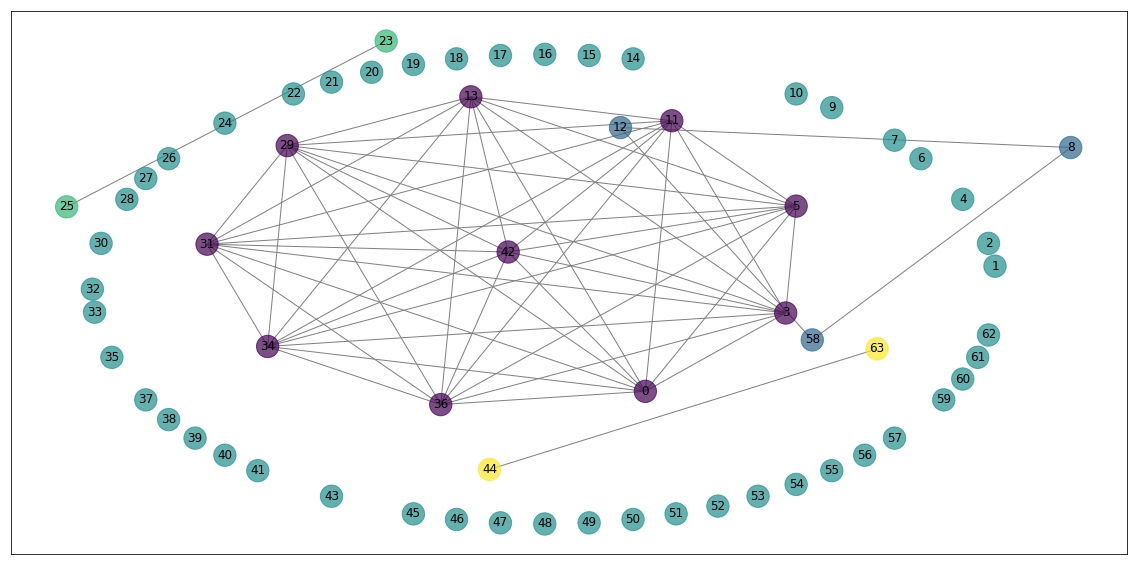

In [53]:
draw_clustered_network(clusters)

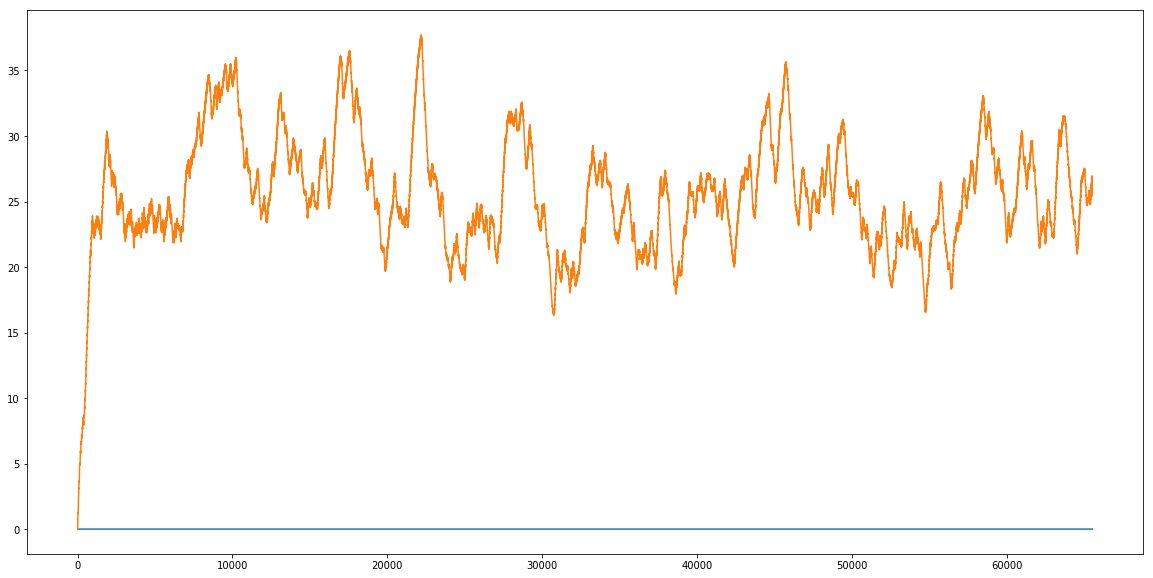

In [26]:
plt.figure(figsize=(20, 10))
for c in clusters[3]:
    plt.plot(W[63, c])
plt.show()

0.00265192284298
12
12


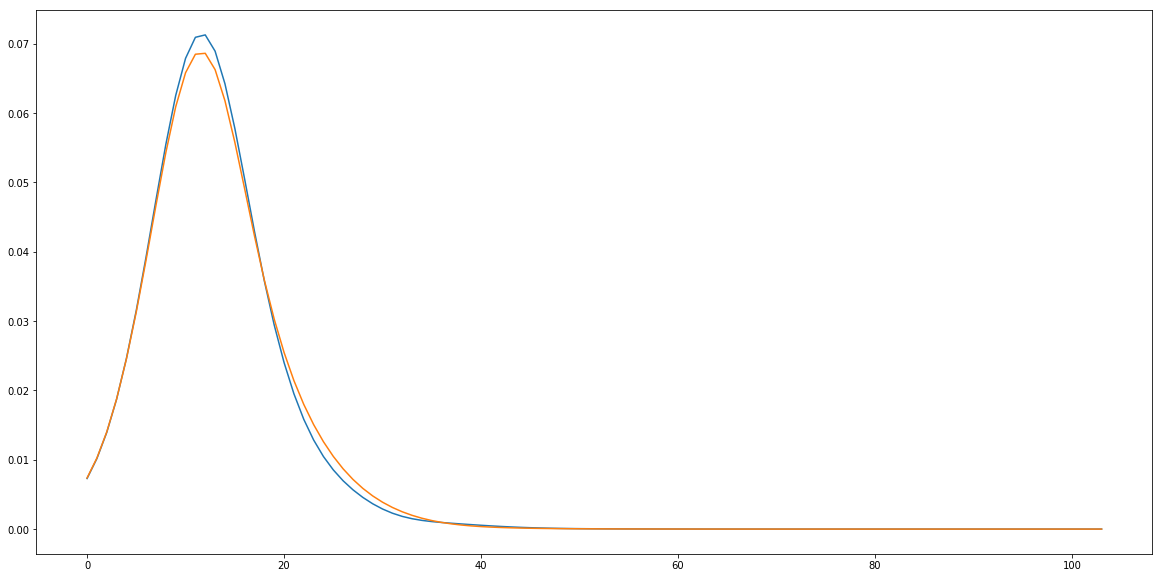

In [35]:
#dist1 = CWTDistribution(W[8, 12, 6000:10096], Ricker()) 
dist1 = CWTDistribution(W[63, 44, 6000:10096], Ricker()) 
dist2 = CWTDistribution(W[25, 23, 6000:10096], Ricker())
plt.figure(figsize=(20, 10))
plt.plot(dist1.value)
plt.plot(dist2.value)
#plt.plot(dist3.value)
print(dist1.jensen(dist2))
print(dist1.moda)
print(dist2.moda)
plt.show()

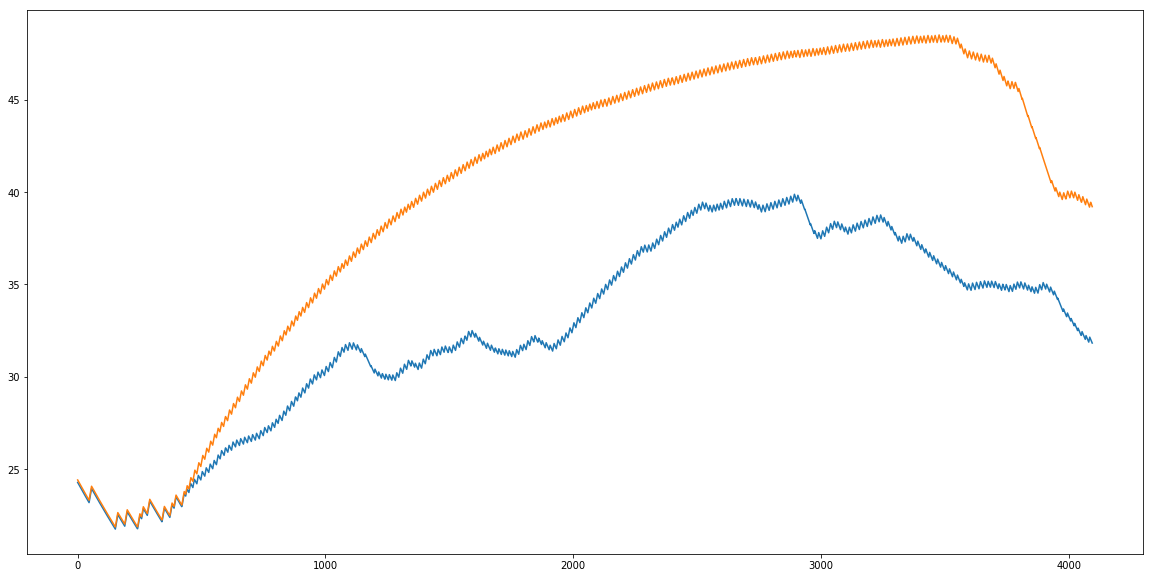

In [137]:
plt.figure(figsize=(20, 10))
plt.plot(W[63, 39, 6000:10096])
plt.plot(signal1)
plt.show()

In [36]:
g = nx.complete_graph(N)        
plt.figure(figsize=(20, 10))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos,
                       node_color = values, node_size = 500)
plt.xticks([])
plt.yticks([])
plt.show()

NameError: name 'values' is not defined